In [1]:
%reload_ext jupyter_black

# Configure warnings and logging
import os
import warnings

warnings.simplefilter("ignore")  # change the filter in this process
os.environ["PYTHONWARNINGS"] = "ignore"  # also affect subprocesses

# **Introduction**

**About Dataset**

* **Breast cancer** is one of the **most common** causes of death among **women worldwide**. Early detection helps in reducing the **number of early deaths**. The data reviews the **medical images of breast cancer** using ultrasound scan. **Breast Ultrasound Dataset** is categorized into **three classes** $:$ **normal, benign, and malignant images**. **Breast ultrasound images** can produce great results in **classification, detection, and segmentation** of breast cancer when combined with machine learning. 

* The data collected at baseline include **breast ultrasound images among women** in ages between 25 and 75 years old. This data was collected in **2018**. The number of patients is **600 female patients**. The dataset consists of **780 images** with an **average image size of 500*500 pixels**. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into **three classes, which are normal, benign, and malignant**.

# **Imports**

In [2]:
# common
import os
from pathlib import Path

import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

In [3]:
# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, Subset

In [4]:
# Data
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import v2

# Data Viz
import matplotlib.pyplot as plt

# **Data**

### setup custom Dataset

In [5]:
class CustomImageDataset(Dataset):
    def __init__(
        self, annotations_file, img_dir, transform=None, target_transform=None
    ):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, mask_path = (
            os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]),
            os.path.join(self.img_dir, self.img_labels.iloc[idx, 1]),
        )
        image, mask = (
            read_image(img_path, mode=ImageReadMode.RGB),
            read_image(mask_path, mode=ImageReadMode.GRAY),
        )
        label = self.img_labels.iloc[idx, 2]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.transform(mask)

        return image, mask, label, idx

In [6]:
IMAGE_SIZE = 256

In [7]:
transforms = v2.Compose(
    [
        v2.ToDtype(torch.uint8, scale=True),
        v2.Resize(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=True),
        v2.ToDtype(torch.float32, scale=True),
        # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        v2.Grayscale(num_output_channels=3),
    ]
)

In [8]:
target_transforms = v2.Compose(
    [
        transforms,
        v2.ToDtype(torch.int64, scale=True),
    ]
)

## 1. Create Dataset

In [9]:
IMAGE_DIR = "Dataset_BUSI_with_GT/"

In [10]:
BreastCancerDataset = CustomImageDataset(
    annotations_file=IMAGE_DIR + "labels.csv",
    img_dir=IMAGE_DIR,
    transform=transforms,
    target_transform=target_transforms,
)

## 2. Split into train / test partitions

In [11]:
TEST_SET_SIZE = 0.2
SEED = 35037

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices = train_test_split(
    range(len(BreastCancerDataset)),
    stratify=BreastCancerDataset.img_labels.CLASS,
    test_size=TEST_SET_SIZE,
    random_state=SEED,
)

# generate subset based on indices
train_split = Subset(BreastCancerDataset, train_indices)
test_split = Subset(BreastCancerDataset, test_indices)

## 3. Create Dataloaders

In [14]:
BATCH_SIZE = 32

In [15]:
# create batches
train_dataloader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_split, batch_size=BATCH_SIZE)

### Show some images

In [16]:
def show_image(images, idx=0, masks=None, cmap="gray", ax=None):
    if ax:
        plt.sca(ax)

    plt.imshow(images[idx].cpu().permute(1, 2, 0))
    if type(masks) != type(None):
        plt.imshow(masks[idx].cpu().permute(1, 2, 0), alpha=0.5, cmap=cmap)

    plt.axis("off")

In [17]:
images, masks, labels, _ = next(iter(train_dataloader))

#### Show image without / with mask

In [18]:
# select a specific image to display
IMAGE_INDEX = 0

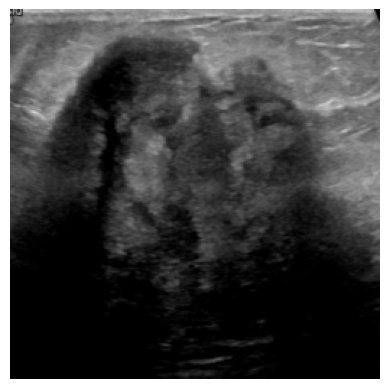

In [19]:
# show image
show_image(images, IMAGE_INDEX)

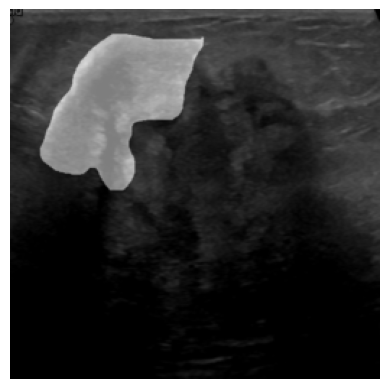

In [20]:
# show masked image
show_image(images, IMAGE_INDEX, masks)

#### **Show masked images with different color maps**

In [21]:
# "binary", "afmhot", "copper"
CMAP = "jet"

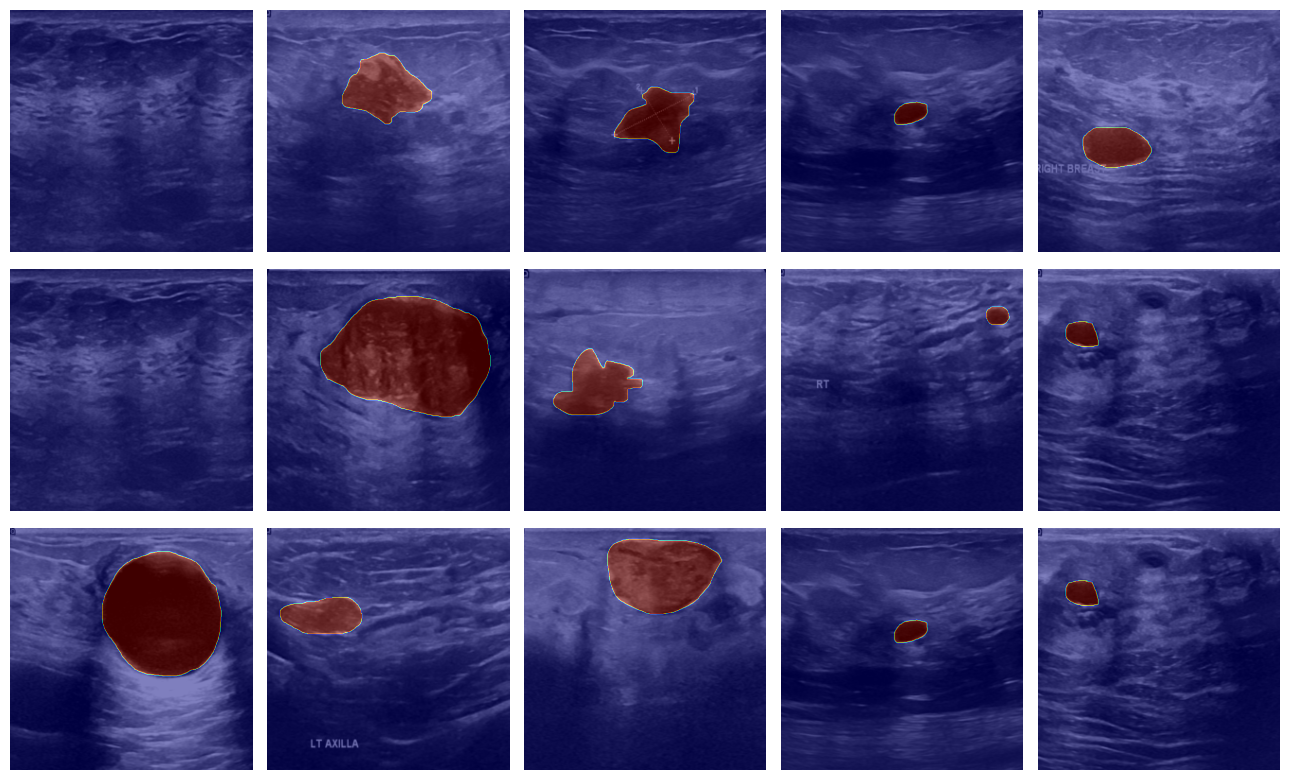

In [22]:
fig, axs = plt.subplots(figsize=(13, 8), nrows=3, ncols=5)
axs = axs.flatten()
for i in range(15):
    id = np.random.randint(len(images))
    show_image(idx=id, images=images, masks=masks, cmap=CMAP, ax=axs[i])
plt.tight_layout()
plt.show()

# ***U-Net***
paper: https://arxiv.org/abs/1505.04597

implementation based on https://github.com/milesial/Pytorch-UNet/tree/master

### **Modules**

In [23]:
class DoubleConv(nn.Module):
    """
    (conv 3x3 -> [BN] -> ReLU) x 2
    blue arrow in Fig. 1
    """

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """
    (max pool 2x2 -> DoubleConv)
    red arrow in Fig. 1
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """
    (up-conv 2x2 -> DoubleConv)
    green arrow in Fig. 1
    """

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)

        return self.conv(x)


class OutConv(nn.Module):
    """
    (conv 1x1)
    turquoise arrow in Fig. 1
    """

    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

## **Model**

In [24]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

        for m in self.modules():
            instance = "conv2d" if isinstance(m, nn.Conv2d) else ""
            if instance:
                nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain(instance))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

### Recall
#### MAGIC NUMBERS
```python
IMAGE_DIR = "Dataset_BUSI_with_GT/"

TEST_SET_SIZE = 0.2
SEED = 35037

BATCH_SIZE = 32
```

#### 1. Create Dataset
```python
BreastCancerDataset = CustomImageDataset(
    annotations_file=IMAGE_DIR + "labels.csv",
    img_dir=IMAGE_DIR,
    transform=transforms,
    target_transform=target_transforms,
)
```

#### 2. Split into train / test partitions
```python
# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices = train_test_split(
    range(len(BreastCancerDataset)),
    stratify=BreastCancerDataset.img_labels.CLASS,
    test_size=TEST_SET_SIZE,
    random_state=SEED,
)

# generate subset based on indices
train_split = Subset(BreastCancerDataset, train_indices)
test_split = Subset(BreastCancerDataset, test_indices)
```

#### 3. Create Dataloaders
```python
# create batches
train_dataloader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_split, batch_size=BATCH_SIZE)
```

## 4. Define the Model

In [25]:
DEVICE = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [26]:
model = UNet(
    n_channels=3, n_classes=2  # BreastCancerDataset.img_labels.CLASS.unique().shape[0]
)

In [27]:
from torchinfo import summary

summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [32, 2, 256, 256]         --
├─DoubleConv: 1-1                             [32, 64, 256, 256]        --
│    └─Sequential: 2-1                        [32, 64, 256, 256]        --
│    │    └─Conv2d: 3-1                       [32, 64, 256, 256]        1,728
│    │    └─BatchNorm2d: 3-2                  [32, 64, 256, 256]        128
│    │    └─ReLU: 3-3                         [32, 64, 256, 256]        --
│    │    └─Conv2d: 3-4                       [32, 64, 256, 256]        36,864
│    │    └─BatchNorm2d: 3-5                  [32, 64, 256, 256]        128
│    │    └─ReLU: 3-6                         [32, 64, 256, 256]        --
├─Down: 1-2                                   [32, 128, 128, 128]       --
│    └─Sequential: 2-2                        [32, 128, 128, 128]       --
│    │    └─MaxPool2d: 3-7                    [32, 64, 128, 128]        --
│    │    └

In [28]:
_ = model.to(device=DEVICE)

Get summary of model parameters

## 5. Set up the loss, the optimizer, the learning rate scheduler

### Loss function / criterion

#### Implement weight map as specified in U-Net paper
source: https://gist.github.com/rok/5f4314ed3c294521456c6afda36a3a50

In [29]:
WEIGH_CLASSES = {0: 1, 1: 5, 2: 5}  # normal  # benign  # malignant
EVAL_IMAGE_INDEX = 500

In [30]:
from skimage.measure import label
from scipy.ndimage.morphology import distance_transform_edt

In [31]:
def unet_weight_map(y, wc=None, w0=10, sigma=5):
    """
    Generate weight maps as specified in the U-Net paper
    for boolean mask.

    "U-Net: Convolutional Networks for Biomedical Image Segmentation"
    https://arxiv.org/pdf/1505.04597.pdf

    Parameters
    ----------
    mask: Numpy array
        2D array of shape (image_height, image_width) representing binary mask
        of objects.
    wc: dict
        Dictionary of weight classes.
    w0: int
        Border weight parameter.
    sigma: int
        Border width parameter.

    Returns
    -------
    Numpy array
        Training weights. A 2D array of shape (image_height, image_width).
    """

    print(y.shape)
    y = y.detach().cpu().numpy().squeeze()
    w = np.zeros_like(y)

    for j, y_ in enumerate(y):
        labels = label(y_)

        no_labels = labels == 0
        label_ids = sorted(np.unique(labels))

        if len(label_ids) > 1:
            distances = np.zeros((y_.shape[0], y_.shape[1], len(label_ids)))

            for i, label_id in enumerate(label_ids):
                distances[:, :, i] = distance_transform_edt(labels != label_id)

            distances = np.sort(distances, axis=2)
            d1 = distances[:, :, 0]
            d2 = distances[:, :, 1]
            w_ = w0 * np.exp(-1 / 2 * ((d1 + d2) / sigma) ** 2) * no_labels
            w[j] = w_

            if wc:
                class_weights = np.zeros_like(y_)
                for k, v in wc.items():
                    class_weights[y_ == k] = v
                w[j] = w[j] + class_weights
        else:
            w[j] = np.zeros_like(y_)

    return w

In [32]:
_images, _masks, _, _ = next(
    iter(DataLoader(BreastCancerDataset, batch_size=len(BreastCancerDataset)))
)

WEIGHT_MAPS = unet_weight_map(_masks, wc=WEIGH_CLASSES, w0=10, sigma=5)
WEIGHT_MAPS = torch.from_numpy(WEIGHT_MAPS).to(DEVICE)

torch.Size([763, 1, 256, 256])


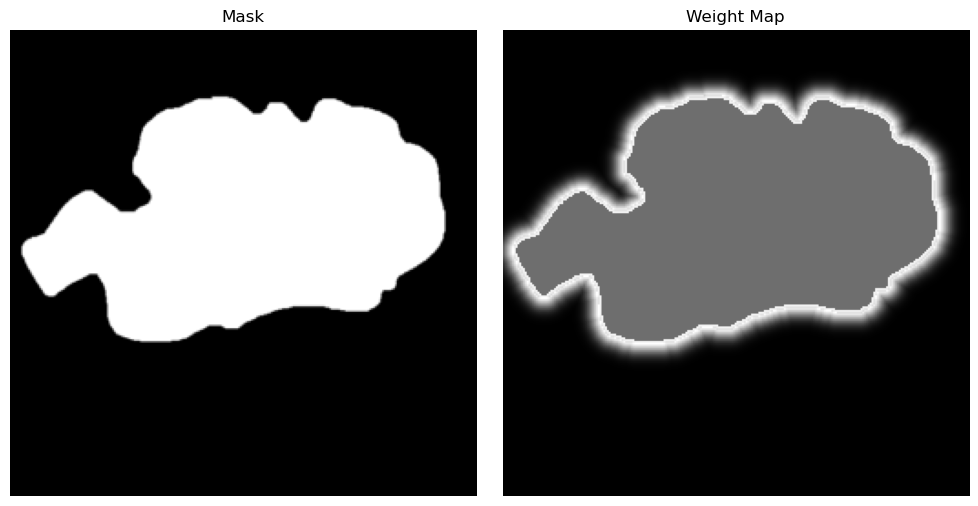

In [33]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)

axs[0].imshow(_masks.cpu()[EVAL_IMAGE_INDEX].squeeze(), cmap="gray")
axs[0].set_title("Mask")
axs[0].axis("off")

axs[1].imshow(WEIGHT_MAPS.cpu()[EVAL_IMAGE_INDEX], cmap="gray")
axs[1].set_title("Weight Map")
axs[1].axis("off")

plt.tight_layout()
plt.show()

#### Loss function itself

In [34]:
class mIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(mIoULoss, self).__init__()
        self.classes = n_classes

    def forward(self, inputs, target_oneHot):
        # inputs => N x Classes x H x W
        # target_oneHot => N x Classes x H x W

        N = inputs.size()[0]

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs, dim=1)

        # numerator Product
        inter = inputs * target_oneHot
        # sum over all pixels N x C x H x W => N x C
        inter = inter.view(N, self.classes, -1).sum(2)

        # Denominator
        union = inputs + target_oneHot - (inputs * target_oneHot)
        ## Sum over all pixels N x C x H x W => N x C
        union = union.view(N, self.classes, -1).sum(2)

        loss = inter / union

        ## Return average loss over classes and batch
        return loss.mean()

In [35]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0) -> None:
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        # flatten label and prediction tensors
        pred = pred.contiguous()
        target = target.contiguous()

        # get intersection
        intersection = (pred * target).sum(dim=(2, 3))

        # calculate dice score
        loss = 1 - (
            (2.0 * intersection + self.smooth)
            / (pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + self.smooth)
        )

        # return losses average over classes and batch
        return loss.mean()

In [36]:
criterion1 = nn.CrossEntropyLoss(reduction="none")
criterion2 = DiceLoss()

### setup Optimizer

In [46]:
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
MOMENTUM = 0.99

In [47]:
# optimizer = optim.SGD(
#     model.parameters(),
#     lr=LEARNING_RATE,
#     weight_decay=WEIGHT_DECAY,
#     momentum=MOMENTUM,
# )

optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    amsgrad=True,
)

# optimizer = optim.RMSprop(
#     model.parameters(),
#     lr=LEARNING_RATE,
#     weight_decay=WEIGHT_DECAY,
#     momentum=MOMENTUM,
#     # foreach=True,
# )

### LR Scheduler

In [48]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "max", patience=5
)  # goal: maximize Dice score

## 6. Train the Model

In [49]:
EPOCHS = 5
N_TRAIN_EXAMPLES = len(train_indices)

In [50]:
def step(images, masks, idx, eval=False):
    images = images.to(DEVICE)
    masks = masks.squeeze().long().to(DEVICE)
    idx = idx.to(DEVICE)

    masks_pred = model(images)
    masks_weight = WEIGHT_MAPS.index_select(dim=0, index=idx).unsqueeze(1).to(DEVICE)

    # convert to one-hot encoding
    output = F.softmax(masks_pred, dim=1).float()
    target = F.one_hot(masks, model.n_classes).permute(0, 3, 1, 2).float()

    # calculate loss
    loss1 = criterion1(output, target)
    loss2 = criterion2(output, target)
    loss = 0.5 * torch.mean(loss1 * masks_weight) + 0.5 * torch.mean(loss2)

    return loss if not eval else (loss, output)

In [51]:
def evaluate_image(global_step=0, DEVICE=DEVICE, EVAL_IMAGE_INDEX=EVAL_IMAGE_INDEX):
    input = _images[EVAL_IMAGE_INDEX].unsqueeze(0).to(DEVICE)
    target = _masks[EVAL_IMAGE_INDEX].long().to(DEVICE)

    output = F.softmax(model(input), dim=1).float()
    target = F.one_hot(target, model.n_classes).permute(0, 3, 1, 2).float()

    _, axs = plt.subplots(ncols=2, figsize=(10, 5))
    for i, (mask, title) in enumerate(zip([output, target], ["Output", "Target"])):
        mask = torch.argmax(mask, dim=1).unsqueeze(1)
        show_image(
            input,
            0,
            mask,
            cmap="jet",
            ax=axs[i],
        )
        axs[i].set_title(title)
    if global_step:
        plt.savefig("eval" + str(global_step) + ".png")

In [52]:
def evaluate(model, test_dataloader, global_step, DEVICE):
    evaluate_image(global_step, DEVICE, EVAL_IMAGE_INDEX=100)

    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        data, target, _, idx = next(iter(test_dataloader))

        test_loss_, output = step(data, target, idx, eval=True)
        test_loss += test_loss_.item()

        pred = output.argmax(
            dim=1, keepdim=True
        )  # get the index of the max log-probability
        correct += pred.eq(target.to(DEVICE).view_as(pred)).sum().item()

    test_loss /= len(test_dataloader.dataset)

    return test_loss, correct / len(test_dataloader.dataset)

Epoch 5/5: 100%|██████████| 610/610 [00:31<00:00, 19.43img/s, loss (batch)=0.417, loss (epoch)=9.47]


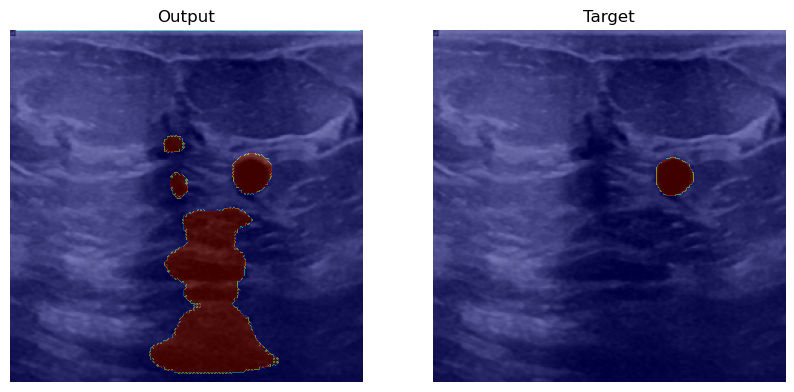

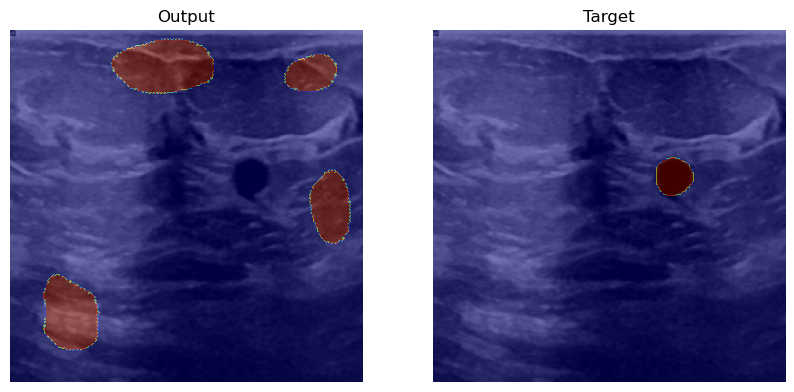

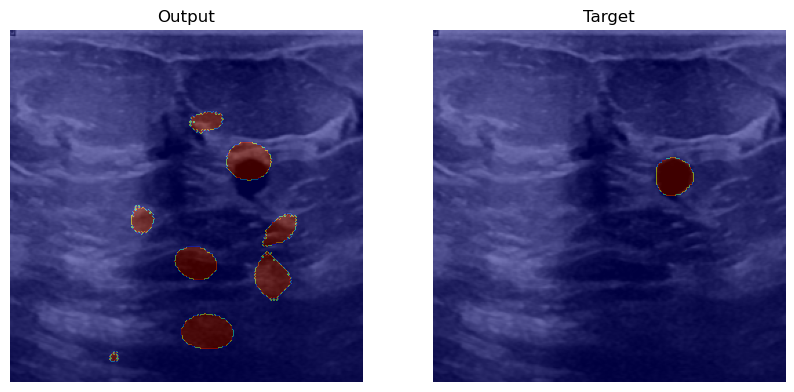

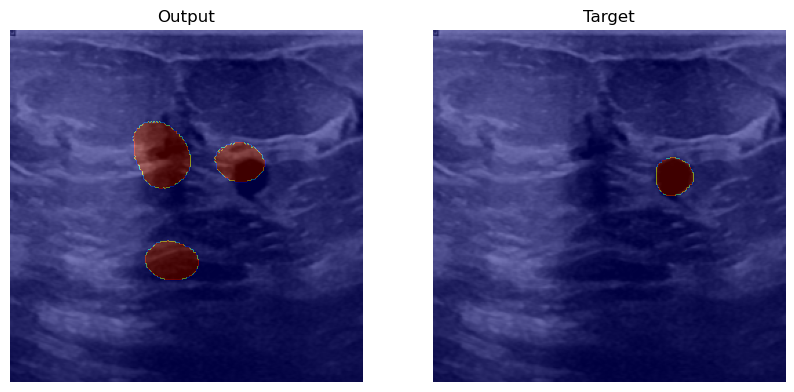

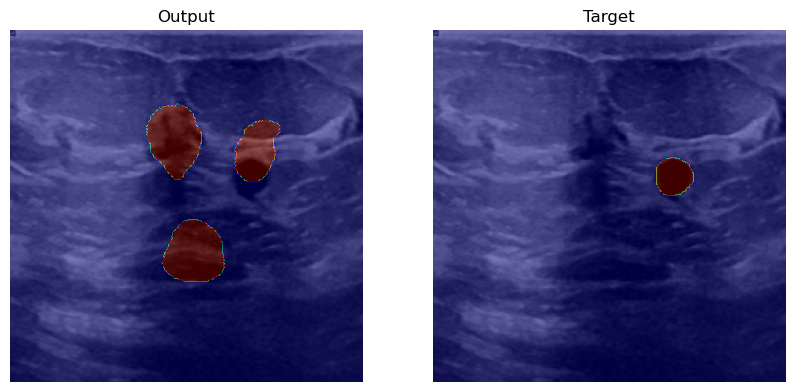

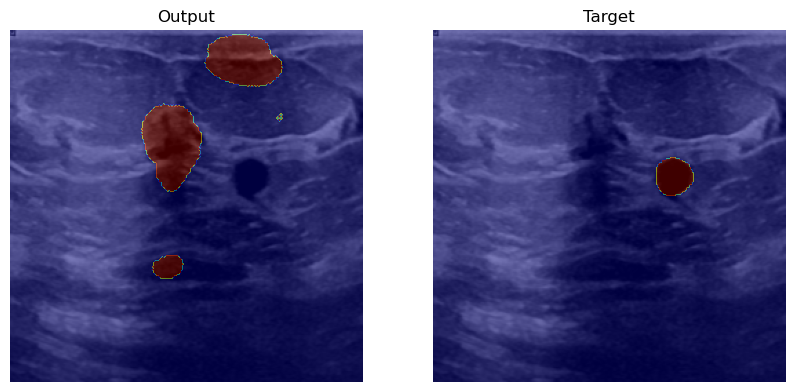

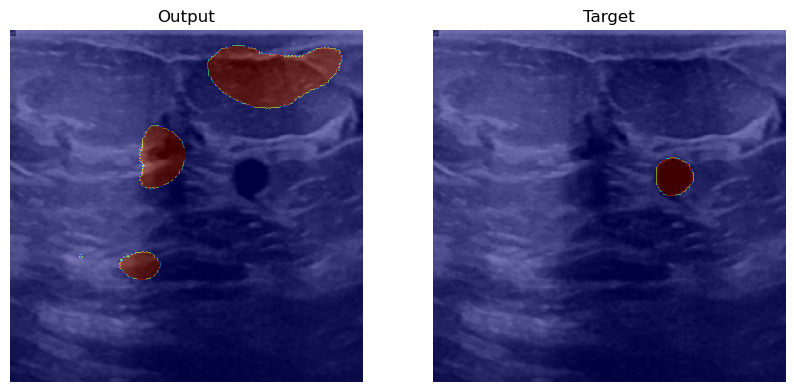

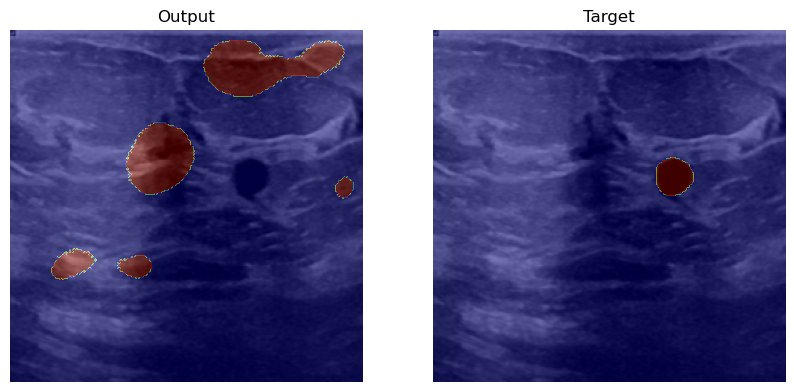

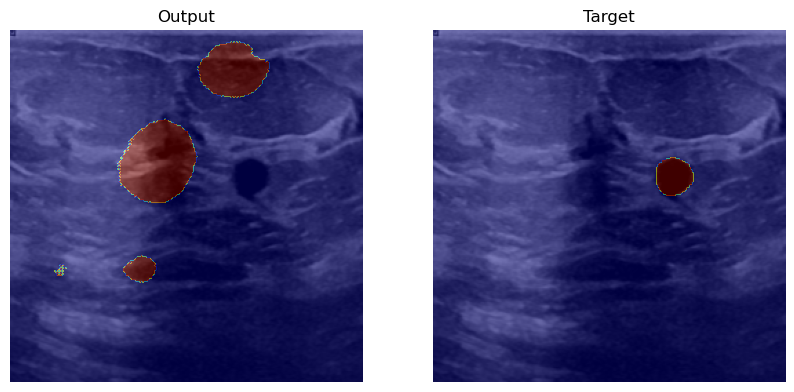

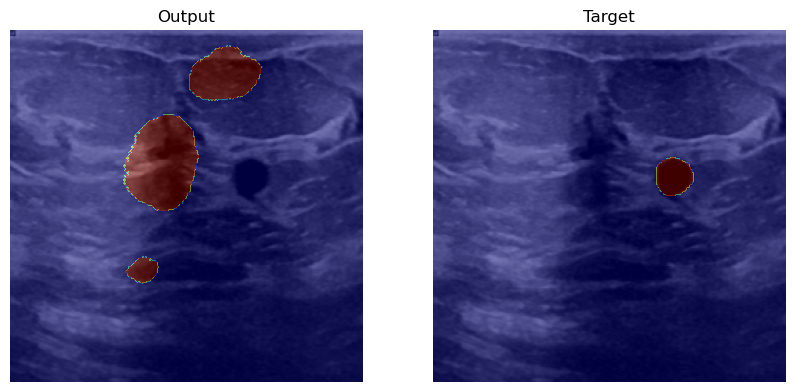

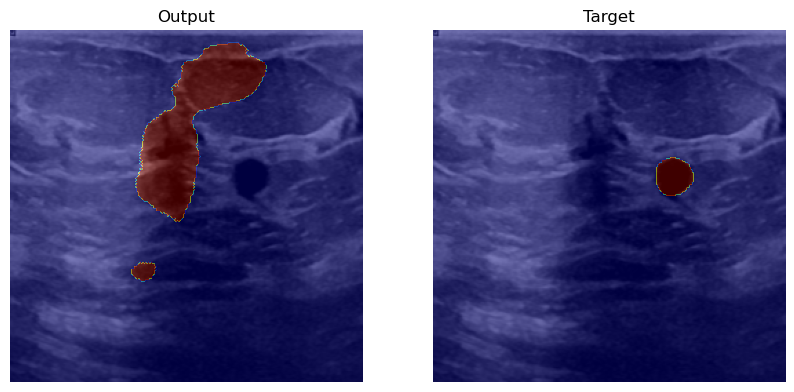

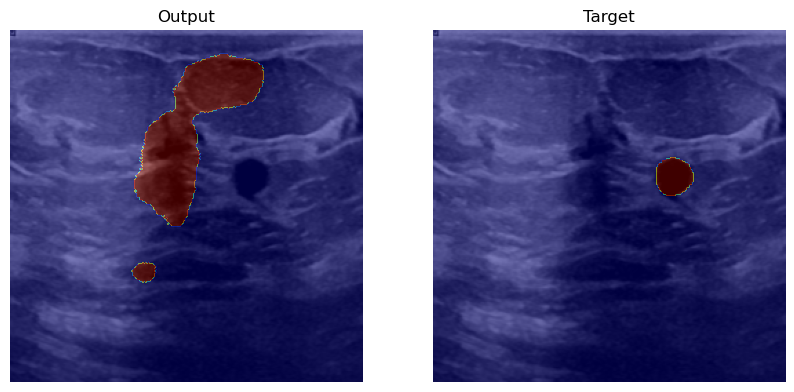

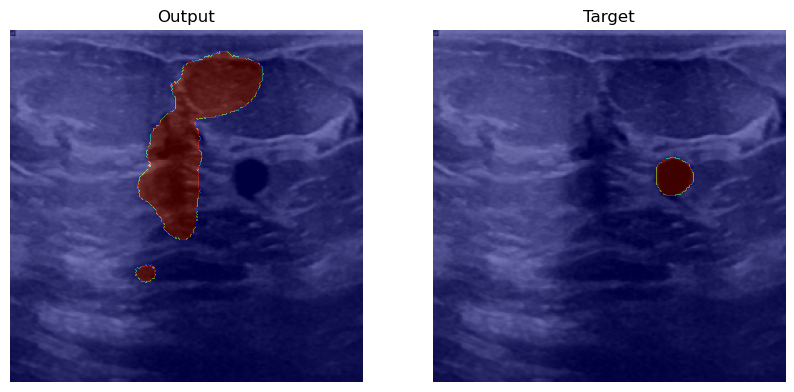

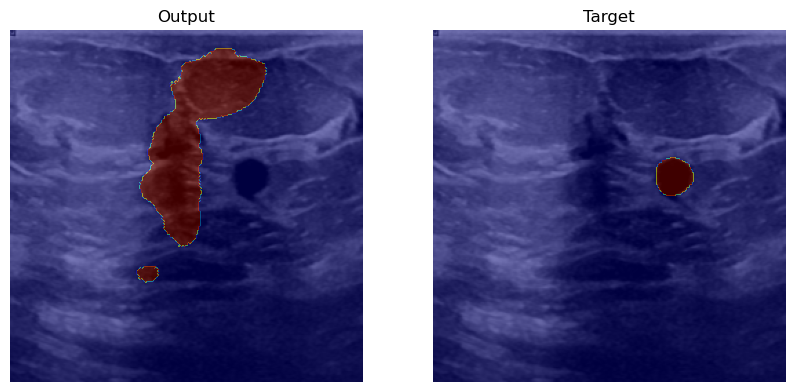

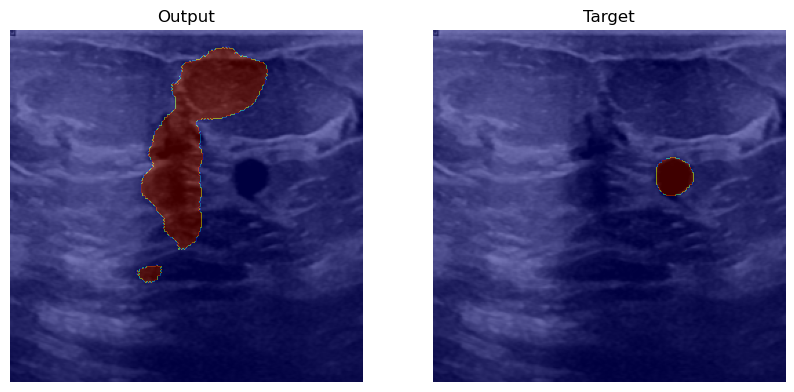

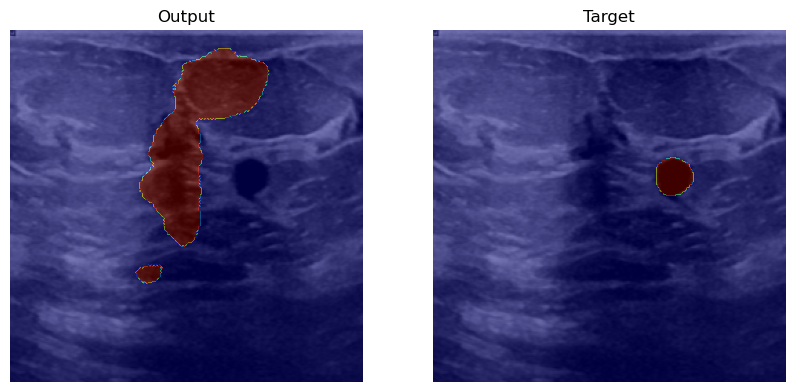

In [53]:
global_step = 0

for epoch in range(1, EPOCHS + 1):
    # set model to training mode
    model.train()

    epoch_loss = 0
    division_step = N_TRAIN_EXAMPLES // (3 * BATCH_SIZE)

    with tqdm(
        total=N_TRAIN_EXAMPLES, desc=f"Epoch {epoch}/{EPOCHS}", unit="img"
    ) as pbar:
        # iterate over batches
        for images, masks, _, idx in train_dataloader:
            assert images.shape[1] == model.n_channels, (
                f"Network has been defined with {model.n_channels} input channels, "
                f"but loaded images have {images.shape[1]} channels. Please check that "
                "the images are loaded correctly."
            )

            model.train()

            # clear gradients
            optimizer.zero_grad()

            # compute loss and do backward pass
            loss = step(images, masks, idx)
            loss.backward()

            # update weights
            optimizer.step()

            # update tqdm
            pbar.update(images.shape[0])
            global_step += 1
            epoch_loss += loss.item()
            pbar.set_postfix(
                **{"loss (batch)": loss.item(), "loss (epoch)": epoch_loss}
            )

            # Evaluation round
            if division_step > 0:
                if global_step % division_step == 0:
                    val_score = evaluate(
                        model,
                        test_dataloader,
                        global_step=global_step,
                        DEVICE=DEVICE,
                    )
                    scheduler.step(val_score[0])

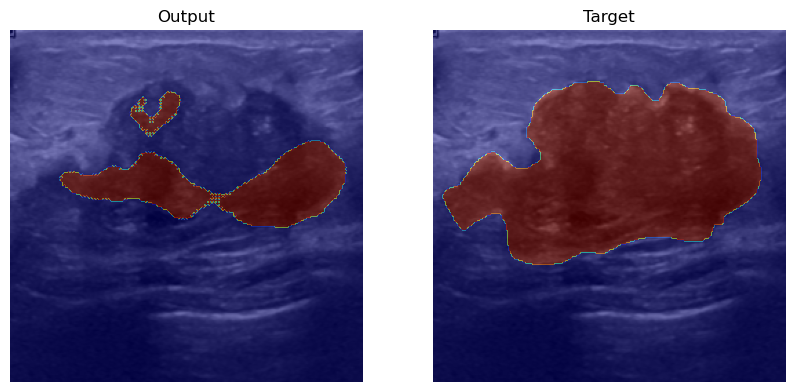

In [56]:
evaluate_image(EVAL_IMAGE_INDEX=500)